In [35]:
## import
import lamindb as ln
import scanpy as sc

from scprint import scPrint
from scprint.dataloader import Collator, AnnDataCollator
from scdataloader.data import SimpleAnnDataset, Dataset
from scdataloader import Preprocessor
from torch.utils.data import DataLoader

from scdataloader.utils import load_genes

import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
import pandas as pd
import tqdm

from scvi.data import AnnDataManager
from scvi.data.fields import CategoricalObsField, LayerField
from scvi.dataloaders import AnnDataLoader
import scvi

from scib_metrics.benchmark import Benchmarker

from lightning.pytorch import Trainer

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  %reload_ext autoreload


## preparing the model

In [38]:
model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt')

In [17]:
ensembl = load_genes(['NCBITaxon:9606'])
ensembl['ensembl_gene_id'] = ensembl.index

## Loading the data

In [18]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint

In [19]:
#adata = sc.read(
#    "data/lung_atlas.h5ad",
#    backup_url="https://figshare.com/ndownloader/files/24539942",
#)

In [20]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad')

In [21]:
Preprocessor()(adata.copy())
# cannot preprocess (first of all not raw counts and also doesn't have standardized values)

ValueError: Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess

In [22]:
# You need to use counts
adata.X = adata.layers['counts']
del adata.layers

In [23]:
# you need to have ensembl gene ids 
# # removing the other ones
var = adata.var.merge(ensembl.drop_duplicates('symbol').set_index('symbol', drop=False), left_index=True, right_index=True, how='inner').sort_values(by="ensembl_gene_id").set_index('ensembl_gene_id')
adata = adata[:, var['symbol']]
adata.var = var

# adding back the missing genes
unseen = set(ensembl.index) - set(adata.var.index)
# adding them to adata
emptyda = ad.AnnData(
    csr_matrix((adata.shape[0], len(unseen)), dtype=np.float32),
    var=pd.DataFrame(index=list(unseen)),
    obs=pd.DataFrame(index=adata.obs.index),
)
adata = ad.concat([adata, emptyda], axis=1, join="outer", merge="only")
# do a validation function
adata.uns["unseen_genes"] = list(unseen)
adata = adata[:, adata.var.sort_index().index]

# Add at least the organism you are working with
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id'
    var: 'symbol', 'ncbi_gene_id', 'biotype', 'description', 'synonyms', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes'

In [24]:
adataset = SimpleAnnDataset(adata, obs_to_output=['organism_ontology_term_id'])
col = Collator(organisms=["NCBITaxon:9606",], valid_genes=model.genes, max_len=8000)#mdataset.encoder['organism_ontology_term_id'])
dataloader = DataLoader(adataset, collate_fn=col, batch_size=32, num_workers=2, shuffle=False)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [ ]:
#dataloader = AnnLoader([adata], collate_fn=AnnDataCollator(max_len=5000, organisms=["NCBITaxon:9606",], org_to_id={'NCBITaxon:9606': 0}), batch_size=32, num_workers=1)

In [ ]:
# dataloader = AnnDataLoader(adata_manager, collate_fn=SCVICollator(max_len=5000, organisms=["NCBITaxon:9606",], org_to_id={'NCBITaxon:9606': 0}), batch_size=32, num_workers=1)

In [40]:
trainer = Trainer(limit_predict_batches=10, precision=16)

INFO: Using 16bit Automatic Mixed Precision (AMP)
2024-02-07 11:16:34,097:INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2024-02-07 11:16:34,127:INFO - GPU available: True (cuda), used: True
2024-02-07 11:16:34,097:INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2024-02-07 11:16:34,127:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-07 11:16:34,130:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-07 11:16:34,133:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-02-07 11:16:34,136:INFO - HPU available: False, using: 0 HPUs


In [29]:
model.labels

['cell_type_ontology_term_id',
 'disease_ontology_term_id',
 'assay_ontology_term_id',
 'self_reported_ethnicity_ontology_term_id',
 'sex_ontology_term_id',
 'organism_ontology_term_id']

In [39]:
model.pred_embedding = ['cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id']

In [56]:
model.expr_pred[0].max()

tensor(0.0927)

In [57]:
model.expr_pred[1]

tensor([[2.6941e-01, 2.8711e+00, 6.4701e+00,  ..., 4.4195e-02, 2.4039e+01,
         2.8504e+04],
        [2.1043e-01, 1.5740e+00, 1.5166e+00,  ..., 2.9667e-03, 3.4909e+01,
         1.1493e+03],
        [3.1100e-01, 1.7270e+00, 1.1624e+00,  ..., 1.0084e+04, 1.3153e+04,
         8.2928e+01],
        ...,
        [2.8702e-02, 5.9480e-01, 2.9531e-01,  ..., 8.7550e-02, 5.6518e-03,
         4.8215e-01],
        [1.1576e-01, 1.1033e+00, 1.5462e+00,  ..., 2.7905e-01, 1.7225e-01,
         4.6862e-02],
        [9.1751e-02, 1.7599e-01, 1.3692e+00,  ..., 3.2155e+00, 2.2173e-04,
         5.9821e-02]])

In [53]:
torch.nn.functional.sigmoid(model.expr_pred[2].to(torch.float32))[:,-5:]

tensor([[1.7917e-02, 4.7548e-01, 9.6102e-01, 7.8166e-01, 2.0062e-07],
        [7.0487e-01, 9.3109e-01, 9.9897e-01, 9.1352e-01, 2.3564e-01],
        [7.5455e-01, 3.2338e-01, 3.7480e-07, 2.4061e-06, 1.3207e-01],
        ...,
        [5.1442e-05, 2.6664e-01, 4.3863e-01, 3.3633e-01, 3.4544e-01],
        [9.0346e-01, 6.8342e-01, 3.7182e-01, 9.4815e-01, 7.4484e-01],
        [2.5119e-04, 7.1978e-01, 4.6855e-01, 9.7759e-01, 7.5110e-01]])

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-07 11:41:12,287:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


couldn't log to tensorboard
couldn't log to wandb


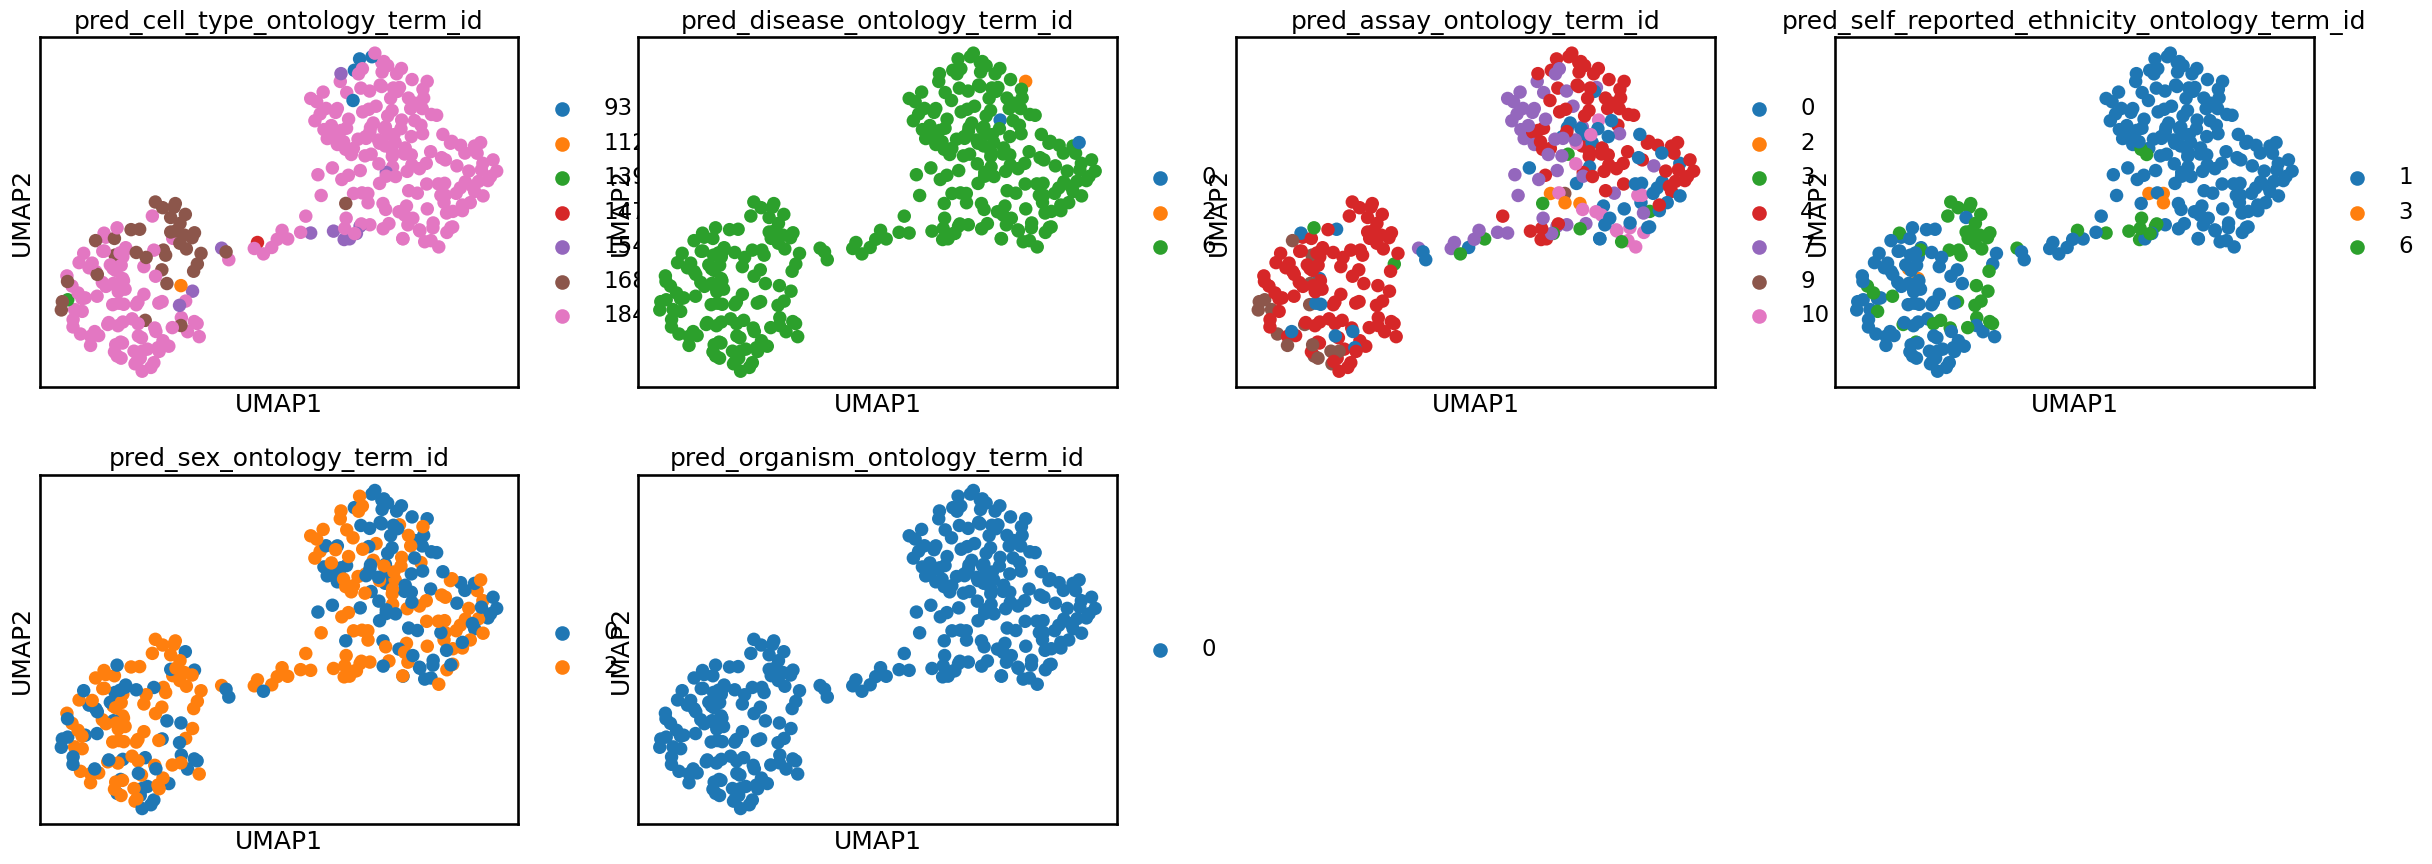

In [48]:
predictions = trainer.predict(model, dataloader)

In [42]:
predictions

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
adata.X.iloc[0].to_array()

In [ ]:
model

## results from running it on most famous methods

![](https://scib-metrics.readthedocs.io/en/stable/_images/72bdb33d77de77ce505e24fef1d700c2b91985b1d3fcce1c2b1dd7a35c8a647f.png)

In [ ]:
## load a random dataset

In [ ]:
## do scGPT finetuning task (reusing the helper functions I have) and the notebook that they provide

In [ ]:
## create a task/function for scPrint

In [ ]:
## try to do an embedding from the regulon / single cell type matrix outputted by scenic

In [ ]:
## push it to a function on BenGRN